# Data Representation Design Patterns

ML models us a mathematical funciton that is defined to operate on specific types of data only. Real world data might not be able to be plugged straight into ML models. We sometime need to transform features so that can be used by ML models. The process of creating features to represent the input data is called feature engineering, and so we can think of featur engineering as a way of selecting the data representation.

Some models can learn the data representation e.g. a decision know can learn what threshold to split a float feature on. Embeddings are another design pattern that deep neural networks are capable of learning. Embeddings represent are dense and lower-dimensional compared to the input which can be sparse. The learning algorithm needs to extract the mose salient information from the input and represent it in a more concise way in the feature. The process of learning features to represnet the input is called feature extraction. We can think of learnable data representations e.g. embeddings as automatically engineered features.

Data representaiton doesn't need to be learned or fixed, a hybrid is also possible. The hashed feature design pattern is deterministic, but doesn't require a model to now all the potential values that a particular input can take.

## Simple Data Representations 

### Numerical Inputs

Mose ML models work on numerical inputs. If a feaure is numerical we can (doesn't mean we should) leave it unchanged.

#### Why Scaling is Desirable

A lot of ML models uses an optimiser that is tuned to work well with number in the range [-1, 1] range, scaling the numeric values to lie in that range can be beneficial.

Gradient descent optimisers require more steps to converge as the curvature of the loss function increases. This is beasue the derivatives of features with larger relative magnitudes will tend to be larger as well, and so will leand to abnormal weight updates. The large weight updates will require more steps to converge and thereby increase the computational load. "Centreing" the data to lie in the [-1 , 1] range makes the error function more spherical. Therefore, models trained with transformed data tend to converge faster and are therefore faster/cheaper to train. In addition, the [-1, 1] range offers the most floating point precision.

A quick test to do is to load the diabetes dataset from SKLearn and train a liner model with scaled and unscaled features. You should typically see a 9% improvement in the model which just uses on input feature.

Another important reason to scale is that ML models are sensitive to relative magnitudes of the different features. For example, K-Means algorithm uses the euclidean distance as its proximity measure and will end up relying heavily on features with larget magnitudes. Lack of scaling also impacts the performance of L1 or L2 regularisation since the magnitude of weights for a feature depends on the magnitude values for that feature, and so different feature will be affected differently by regularisation. By scaling all features to lie between [-1, 1] we ensure that there is not much of a difference in the relative magnitudes of different features.

#### Linear Scaling

Four forms of linear scaling are typically employed:

- **Min-max Scaling**: The numeric value is linearly scales so that the minimum value that the input can take is scaled to -1 and maximimum to 1
```x1_scaled = (2*x1 - max_x1 - min_x1) / (max_x1 - min_x1)```. The issue with this scaler is that the min and max values need to be estimated from the training dataset, and they are often outliers. The real data often gets shrunk to a very narrow range in [-1, 1] band.
- **Clipping (with min-mix)**: Helps address the problem of outliers by using "reasonable" values instead of estimating the min and max from the training dataset. The numeric value is linearly scaled between these two reasonable bounds, then clipped to lie in the range [-1, 1]. This has the effect of treating outliers as -1 or 1.
- **Z-score normalisation**: Addresses the problem of outliers without requiring prior knowledge of what the reasonable range is by linearly scaling the input using the mean and standard deviation estimated over the training dataset: ```x1_scaled = (x1 - mean_x1) / stddev_x1```. The name of the method reflects the fact that the scaled value has zero mean and is normalised by the standard deviation so that is has unit variance over the training dataset. The scaled value is unbounded, but does not lie between [-1, 1] the majority of the time (67%, if the underlying distribution is normal). Values outside this range get rarer the larger their absolute value gets, but are still present.
- **Winsorizing**: Clip the datset to the 10th and 90th percentile or 5th and 95th. The winsorized value is min-max scaled.

Min-max and clipping tend to work best on uniformly distributed data and Z-score for normally distributed data.

Don't throw away outliers. If we throw away outliers the model will treat outliers in production as the most extreme value in the dataset. We should keep outliers in the training dataset so the model can better reflect how to behave when outliers are encountered. It is valid the throw away invalid data but it is not acceptable to throw away valid data. Thus, we should be justified in throwing away data points that are valid.


#### Non-Linear Transformations

If the data is not uniformly distributed nor distributed like a bell curve it is better to use a non-linear transformation such as taking the logarithm before scaling. Other comming transformations are sigmoid and polynomial expansions (square, square root, cube, cube root and so on). We'll know that we have a good transformation function if the distribution of the transformed value becomes uniform or normally distributed.

Example with wikipedia page views we can apply a logarithm and then take the fourth root and then scale linearly and we get somewhat a bell shaped curve.

It can be difficult to devise a linearising function that makes the distribution look like a bell curve. An easier approach is to `bucketize` the number of views, choosing the bucket boundaries to fit the desired output distribution. A principled approach to choosing these buckets is to do histogram equalisation, where the bins of the histogram are chosed based on quantiles of the raw distribution. In the ideal situation, histogram equalisation results in a uniform distribution.

Another technique to handle skewed distributions is to use a parametric transformation such as `box-cox transformation`. Box-cox chooses a single parameter, lambda, to control the "heteroscedasticity" so that the variance no longer depends on the magnitude. Here, the variance among rarely viewed wikipedia pages will be much smaller than the variance among frequently viewed pages, and Box-cox tries to equalise the variance across all ranges of the number of views. This can be done in sklearn: `sklearn.preprocessing.power_transform` where the method is set to `box_cox`.

#### Array of Numbers

Common idioms to handle arrays of numbers:
- Representing the input array in terms of its buld statistics. For example, length of array, average, median, min, max and so forth.
- Representing the input array in terms of its emprirical distribution i.e. by the 10th, 20th percentile and so on.
- If the array is ordered in a specific way (e.g. time or size), representing the input array by the last three or some other fixed number of items. For arrays of length less than 3, the feature is padded to a length of three with missing values.

All these end up respresenting the variable-length array of data as a fixed-length feature.

### Categorical Inputs

Most modern ML models operate on numerical values, categorical inputs have to be represented as numbers. We could just give an ordinal mapping e.g. `Cat_1=1.0`, `Cat_2=2.0` etc..., But this implies there is order in the categories e.g. `Cat_1` is less than `Cat_2`. If there is no ordinal relationship between categories we need to use a categorical to numerical mapping that allows the model to return the category independently.

#### One-hot Encoding

The simpliest method is one-hot endcoding. If we have three categories the endcodings become:

| Categorical Input | Numeric Feature |
|-------------------|-----------------|
| Category 1        | [1.0, 0.0, 0.0] |
| Category 2        | [0.0, 1.0, 0.0] |
| Category 3        | [0.0, 0.0, 1.0] |

See how the categories are now independent of each other compared to the ordinal approach.

One-hot encoding requires us to know the vocabulary of the categorical input beforehand. 

---

##### Dummy Coding or One-Hot Encoding?

A 2-element feature vector is enough to provide a unique mapping for a vocabulary of size 3:

| Categorical Input | Numeric Feature |
|-------------------|-----------------|
| Category 1        | [0.0, 0.0] |
| Category 2        | [1.0, 0.0] |
| Category 3        | [0.0, 1.0] |

This is called **dummy coding**. Because dummy coding is a more compact representation, it is preferred in statistical models that perform better when the inputs are linearly independent.

Modern ML algorithms, though don't require their inputs to be linearly independent and use methods such as L1 regularisation to prune redundant inputs. The additional degree of freedom allows the framework to transparently handle a missing input in production as all zeros.

| Categorical Input | Numeric Feature |
|-------------------|-----------------|
| Category 1        | [1.0, 0.0, 0.0] |
| Category 2        | [0.0, 1.0, 0.0] |
| Category 3        | [0.0, 0.0, 1.0] |
| (missing)         | [0.0, 0.0, 0.0] |

Therefore, many ML frameworks often support only one-hot encoding.

---

In some situations it can be helpful to treat a numeric input as categorical and map it to one-hot encoded column:

- **When the numeric input is an index**L E.g. day of the week. It maybe more helpful here to recognise the days of the week is not a continuous scale and maybe better represented as one-hot encoded.
- **When the relationship between input and label is not continuous** e.g. days of the week again. If were measuring traffic on Thursday will this impact the traffic on Friday? If not it might be best to one-hot encode the days of the week
- **When is it advantagous to bucket the numeric varialbe** e.g. maybe useful to treat week days differently to weekends

### Array of Categorical Variables

Common idioms to handle arrays of categorical variables include the following:

- Count the occurences of the categories in the array. If arrays can have different sets of categories multi-hot encoding can be used. Where the categories present form the numerical features. e.g. if the vocabulary size is 5 and an array has two cateogories the multi-hot encoding may become: `[1.0, 0.0, 0.0, 1.0, 0.0]`. The output is dependent on the vocabulary size and what categories need to be encoded.
- Use the relative frequency (percentage) of the categories in an array or use TF-IDF
- If the array is ordered in a specific way e.g. time, representing the input array by the last three items. Arrays shorter than three are padded with missing values
- Representing the array by bule statistics, e.g., length of the array, the mode, the median, the 10th/20th... percentile, etc...

## Design Pattern 1: Hashed Feature

Addresses three problems associated with categorical features: vocabulary, model size due to cardinality, and cold start. It does so by grouping he catgorical geatures and accepting the trade-off of collisions in the data representation.

### Problem 

One-hot encoding of categorical data requires knowing the vocabulary size beforehand. This can become a problem is situations where we don't know the vocabulary size. Categories likes these pose a few problems:
- Knowing the vocabulary requires extracting it from the training data. Due to random sampling, it is possible that the taining data does not contain all the possible categories. The vocabulary will be incomplete.
- The categorical variables have high cardinality. Such feature vectors pose several problems in practise. They involve so many weights that the training data may be insufficient. Even if we train the model, the trained model will require a lot of space to store because the entire vocabulary is needed at serving time. Thus we may not be able to deploy the model on smaller devices
- After the model is placed into production the model may not be able to make predictions with new categories.


### Solution

The hashed feature desing pattern represents categorical input variable by doing the following:
1. Converting the categorical input into a unique string
2. Invoking a deterministic (no random seeds or salt) and portable (so that the same algorithm can be used in both training and serving) hashing algorithm on the string
3. Taking the remainder when the hash result is divided b the desired number of bukcets. Typically, the hashing algorithm returns an integer that can be negative and the modulo of a negative integer is negative. So, the absolute value of the result is taken.


e.g. if modulo is 10 the range of the hashed feature will be in the range of [0-9]. If the value is 2 the feature vector is: `[0,0,1,0,0,0,0,0,0,0]` and if it's 9 the feauture vector is: `[0,0,0,0,0,0,0,0,0,1]`

Consider the follwing example where we have 5 categories: ['cat', 'dog', 'ball', 'park', 'tree']. We can then has these with `Farm hash` in the `pyfarmhash` package. Note, that farmhash can return negative values to keep indexes positive we take the `abs` of the hash.

In [7]:
import farmhash
import numpy as np

modulo = 10
print('Encoding for dog')
encoding = [0 for i in range(modulo)]
fingerprint = np.abs(np.uint64(farmhash.fingerprint64('dog')).astype('int64'))
print(fingerprint)
print(fingerprint % modulo)
encoding[fingerprint % modulo] = 1
print(encoding, '\n')

print('Encoding for cat')
encoding = [0 for i in range(modulo)]
fingerprint = np.abs(np.uint64(farmhash.fingerprint64('cat')).astype('int64'))
print(fingerprint)
print(fingerprint % modulo)
encoding[fingerprint % modulo] = 1
print(encoding)

Encoding for dog
1588832979462137504
4
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0] 

Encoding for cat
3328278619729588520
0
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


We then take the modulo of the fingerprint e.g. `fingerprint % 10`. Taking a modulo of 10 would put categories into one of 10 buckets in the range of [0-9]. The value from the modulo becomes the index in the vector which becomes one. This essentially is one-hot encoding but we only get the index and have to construct the array. The following elaborates on this further, the lenth of the array is 10 becuase the modulo equals 10:
- Modulo result = 0, vector = [1,0,0,0,0,0,0,0,0,0]
- Modulo result = 9, vector = [0,0,0,0,0,0,0,0,0,1]
- Modulo result = 3, vector = [0,0,0,1,0,0,0,0,0,0]

In [1]:
from sklearn.feature_extraction import FeatureHasher

In [13]:
h = FeatureHasher(n_features=20, input_type='string')
D = ['dog', 'dog', 'cat','elephant', 'run', 'legging', 'leggings', 'the', 'teh', 'bool', 'loob']
f = h.transform(D)
f.toarray()

array([[ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1., -1., -1.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1., -3.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0., -1., -3.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  

The above example is from sklearn. As you can see the same categories have the same hash vector but the draw back here is that `bool` and `loob` have the same hash!

### Why it Works

Let's say were hashing features into 10 buckets and we have 347 categories.

#### Out-of-Vocabulary Input

Even if the the category was not part of the training dataset, it's hashed feature will be in the range on [0-9]. Therefore, there is no resilience problem during serving. The unknown category will get predictions corresponding with other aiports in the hash bucket. The model will not error out. Of course, the prediction for the missing category won't be accurate (it is unreasonable to expect accurate predictions for unknown categories), but it will be in the right range.

#### High Cardinality

High cardinality is addressed as long as we choose a small enough number of buckets. We don't need to store the vocabulary because the transformation code is independent of the actual data value and the core of the model. It is true that hashing is lossy. We can group categories together that shouldn't be.

#### Cold start

If a new category is added it will initally get predictions corresponding to other categoires in the same bucket as it. Once the model is retrained it should better reflect reality.

### Trade-Offs and Alternatives

The key trade-off here is that we lose model accuracy.

#### Bucket Collision

The modulo part of the hashed feature implementation is a lossy operation. If we have 400 categories and hash bucket size of 100 we are choosing to have 4 categories share a bucket. We are explicitly comprimising on the ability to accurately represent the data (with a fixed vocabulary and one-hot encoding) in order to handle out-of-vocabulary input, cardinality/model size constraints and cold start problems. Do not choose hashed feature in you know the vocabulary beforehand, if the vocaulary size is relatively small (in the thousands is acceptable for a dataset with millions of examples), and if cold start is not a concern.

We cannot simply increase the number of buckets to an extremely high number hoping to avoid collisions altogether. There is still a chance of a collision. Therefore, we should use hashed features only if we are willing to tolerate multiple categorical inputs sharing the same hash bucket value.

#### Skew 

The loss of accuracy is particularly acute when the distribution of categorical input is highly skewed. If a category dominates the bucket the predictions will be skewed towards the dominate category.

#### Hyperparameter Tuning

Choosing the number of buckets can be difficult. It often depends on the problem itself. It is recommended to treat the number of buckets as hyperparameter that is tuned. Make sure the number of buckets remains within a sensible range of the cardinality of the categorical variable being hashed.

#### Cryptographic Hash

What makse the hashed feature lossy is the modulo part of the implementation. In the hashed feature design pattern, we have to use a fingerprint hashing algorithm and not a cryptographic hashing algorithm. This is because the goal of a fingerprint function is to produce a deterministic and unique value. This is a key requirement of preprocessing functions in machine learning, since we need to apply the same function during model serving and get the same hashed value. A fingerprint function does not produce a uniformally distributed output. Cryptographic algorithms such as MD5 or SHA1 do produce uniformaly distributed output, but they are not deterministic and are purposefully make to be computationally expensive. Therefore a cryptographic hash is not suitable in the feature engineering context where we need a deterministic process.

Bottom line is we need to use a fingerprint hashing algorithm, and we need to moduluo the resulting hash.

#### Empty Hash Bukcets

It is possible to have empty hash buckets. Therefore, when using hashed feature columns, it may be benificial to also use L2 regularisation so that the weights associated with the empty bucket will be driven to near zero. This way, if an out-of-vocabulary category falles into an empty bucket, it will not cause the model to become numerically unstable.

## Design Pattern 2: Embeddings

Embeddings are learnable data representations that map high cardianlity data into a lower dimensional space in such a way that the information relevant to the learning problem is preserved. Embeddings are at the heart of modern-day machine learning and have various incarnations throughout the field

### Problem

ML models systematically loog for patterns in the data that capture how the properties of the model's input features releate to the output label. As a result, the data representaion of the input features directly affects the quality of the model. For data representations (text, images, etc...) we need meaningful numeric value to supply our ML model so these features can fit within the typical training paradigm. Embeddings provide a way to handle some of these disparate data types in a way that preserves similarity between items and this improves our models ability to learn those essential patterns.

If we use one-hot endcoding for high-cardinality categorical features as inputs to a ML model leads to a sparse matrix that isn't well suited for a number of ML algorithms.

Second problem with one-hot encoding is that it treats the categorical variables as being independent. However, the data presresentation for related categories should be closer than to unrelated categories.

The same probelm of high cardinality and dependent data also occurs in images and text. Images consist of thousands of pixels, which are not independent of one another. Natural landuage text is drawn from a vocabulay in the tens of thounsands of words, and a word like `walk` is closer to the word `run` than to the word `book`.

### Solution

The embeddings design pattern addresses the problem of represnting high-cardinaltiy data densely in a lower dimenstion by passing thei nput data through an embedding layer that has trainable weights. This will map the high-dimensional, categorical input varibale to a real-valued vector in some low-dimensional space. The weights to create the dense representaion are learned as part of the optimisation of model. In practise, these embeddings end up capturing closeness relationships in the input data.

---
Becuase embeddings capture closeness relationships in the input data in a lower-dimensional representaion, we can use an embedding layer as a replacement for clustering techniques (e.g. customer segmentation) and dimensionality reduction like PCA. Embedding weights are determined in the main model training loop, thus saving the need to cluster to do PCA beforehand.

---

The weights in the embedding layer would be learned as part of the gradient descent procedure when training the model. The embeddings maps a sparse, one-hot encoded vector to a dense vector.

#### Text Embeddings

Text provides a natural setting where it is advantageous to use an embedding layer. Given the cardinality of a vocabulary, one-hot encoding each word isn't practical. This will create an incredibly large high dimensional and sparse matrix for training. Also we'd like similar words to have emdedding close by and unrelated words to be far away in embedding space. Therefore, we use a dense word embedding to vectorise the discrete text input before passing to our model.

To use text in embedding layers we need to tokenise the text into individual words and create a mapping to words to an index. The index corresponds to what embedding belongs to the word.

#### Image Embeddings

Images consist of dense, high-dimensional vectors usually with multiple channels containing raw pixel or frequncy information. In this setting, an amebedding captures a relevant, low-dimensional representation of the input.

We can use pre-trained image models e.g. ResNet and remove the softmax layer. With this layer removed the model now outputs a feature vector for a given input. This feature vectore contains all the relevant information of the image so it is essentially a low-dimensional embedding of the input image.

By training this model on a massive dataset of images/caption pairs, the encoder learns an efficient vector representaion for images. The decoder learns how to translate this vector to a text caption. In this sense, the encoder becomes an Image2Vec embedding machine.

### Why it Works

The embedding layer is just another hidden later of the neural network. The weights are then associated to each of the high-cardinality dimensions, and the output is passed through the rest of the network. Therefore, the weights to create the embedding are learned through the process of gradient descent just like any other weights in the neural network. This means that the resulting vector embeddings represent the most efficient low-dimensional representation of those feature values with respect to the learning task.

By forcing our categorical variable into a lower-dimensional embedding space, we can also learn relationships between the different categories. e.g. "man" and "king" are closely related. Thus, a learned embedding allows us to extract inherent similarities between two separate categories and, given there is a numeric vector representation, we can precisely quantify the similarity between two categorical features.

### Trade-Offs and Alternatives

The main trade-off with using embeddings is the compromised representation of the data. There is loss of information from going to high cardinality to a lower-dimensional representation. In return, we gain information about closeness and context of the items.

#### Choosing the embedding dimension

The exact dimensionality of the embedding is something we choose. Large or small dimension? The lossiness of the representation is controlled by the size of the embedding layer. Choosing a small output dimension will force a lot of information into a small vector space and context can be lost. A large embedding on the other hand loses the learned contextual importance of the features. At the extreme, we're back to the problem encountered with one-hot encoding. The optimal embedding dimension is often found through experimentation, similar to choosing the number of neurons in a deep neural network layer.

Some suggestions to finding the dimensions are the:
- 4th root of the total number of unqiue categories
- 1.6 times the square root of the number of unique elements
Combining both above could give a range which can be tested. The above is guidence.

#### Autoencoders

Training embeddings in a supervised way can be hard because it requires a lot of labeled data. Autoencoders provide one way to get around this need for a massive labeled dataset.

The typical autoencoder architecture, consists of a bottleneck layer, which is essentially an embedding layer. The encoder portion of the network before the bottlenect (the "encoder") maps high-dimensional input into a lower-dimensional embedding layer. The "decoder" maps the representation back to a higher dimensionality, typically the same as the original data. This model is typically to minimise the reconstruction error, forcing the model output to be as similar as possible to the input.

Because the input is the same as the output no additional data is needed. The encoder learns an optimal nonlinear dimension reduction of the input, similar to PCA.

#### Context Language Models

Word2Vec is a well known method for constructing an embedding using shallow nerual networks and combining two techniques: continuous bag of words and a skip-gram model applied on a large corpous of text. The resulting word embeddings learned though word2vec capture the semantic relationships between words so that, in embedding space, the vector representation maintain meaningful distance and directionality. BERT another model, is trained using a masked language model and next sentence prediction. For a masked language model, words are randomly masked from text and the model guesses what the missing word(s) are. Next sentece prediction is a classificaton task where the model predicts whether or not two sentences followed eachother in the original text. 

A pre-trained text embedding, like Word2Vec, NNLN, GLoVE or BERT can be added to a machine learning model to process text features in conjuction with structured inputs and other learned embeddings.

Ultimately, embeddings learn to preserve information relevant to the prescribed training task. In the case of image captioning, the task is to learn how the context of the elements of an image relates to text. In the autoencoder architecture, the label is the same as the feature, so the dimension reduction of the bottleneck attempts to learn everything with no specific contect of what is important.

#### Embeddings in a data warehouse

In data warehouses, natural language text is stored directly as columns and images are typically URLs to files in a cloud storage. In these cases, it simplifies later ML to additionally store the embeddings of the text or images as array-type columns. Doing so, will enable the easy incorporation of such unstructured data into ML models

## Design Pattern 3: Feature Cross

The feature cross design pattern helps models learn relationships between inputs faster by explicitly make each combination of input values a separate feature.

### Problem

Consider the dataset below and we have the task of creating a binary classifier that separates the + and the - labels

Using only the `x1` and `x2` coordinates, it is not possible to find a linear boundary that separates the + and - classes

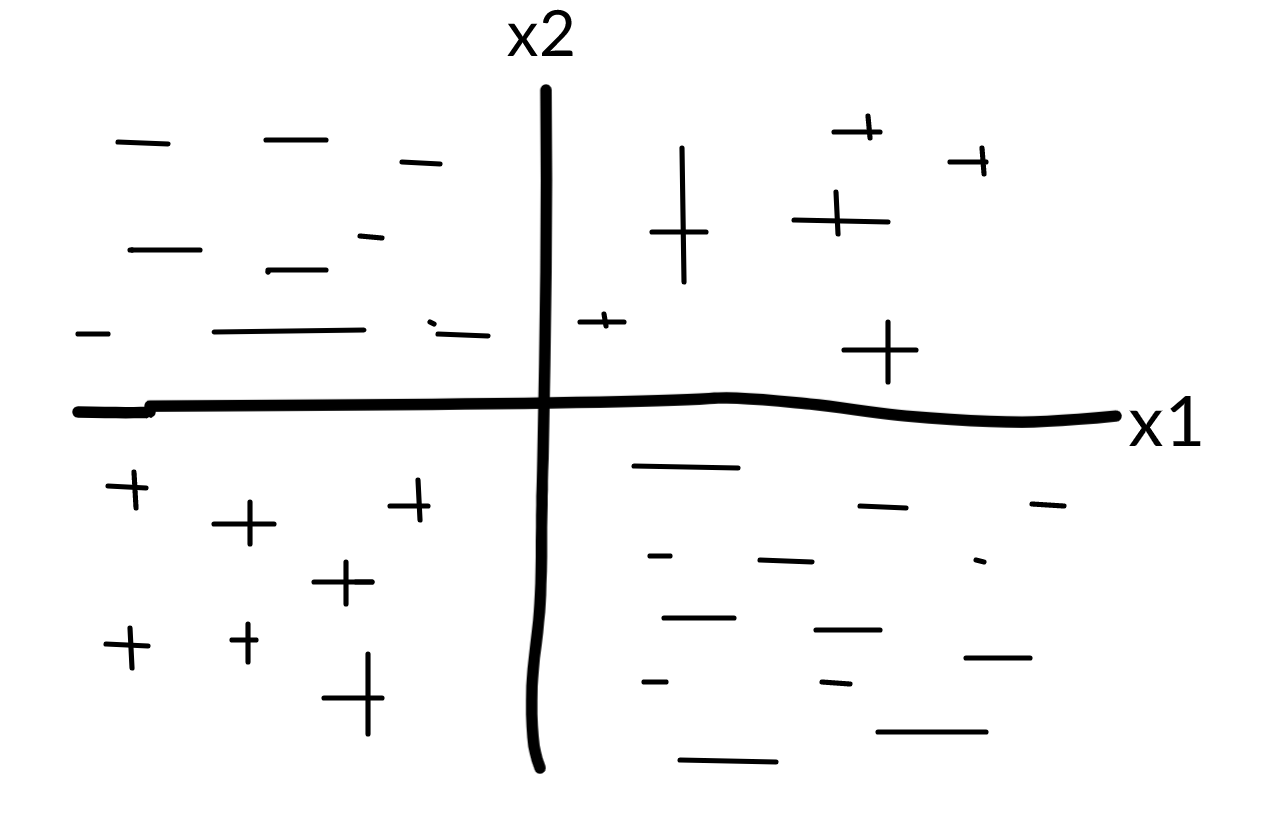

This means that so solve the this problem, we have to make the model more complex, perhaps by adding more layers to the model. However, a simplier solution exists.

### Solution

Feature engineering is the process of using domain knowledge to create new features that aid the machine learning process and increase the predictive power of our model. One commonly used feature enginnering technique is creating a feature cross.

A feature cross is a synthetic feature formed by concatenating two or more categorical features in order to capture the interaction between them. By joining two features in this way, it is possible to encode nonlinearity into the model, which can allow for predictive abilities beyond what each of the featuers would have been able to provide individually. Feature crosses provide a way to have the ML model learn relationships between the features faster. While more complex models like neural networks and trees can learn feature crosses on their own, using feautre crosses explicitly can allow us to get away with training just a linear model. Consequently, feature crosses can speed up model training (less expensive) and reduce model complexity (less training data is needed).

To create a feature column for the dataset above, we can bucketsize `x1` and `x2` each into two buckets, depending on their sign. This converts `x1` and `x2` into categorical features. Let `A` denote the bucket where `x1 >= 0` and `B` the bucket where `x1 < 0`. Let `C` denote the bucker where `x2 >= 0` and `D` the bucket where `x2 < 0`. This is shown below:

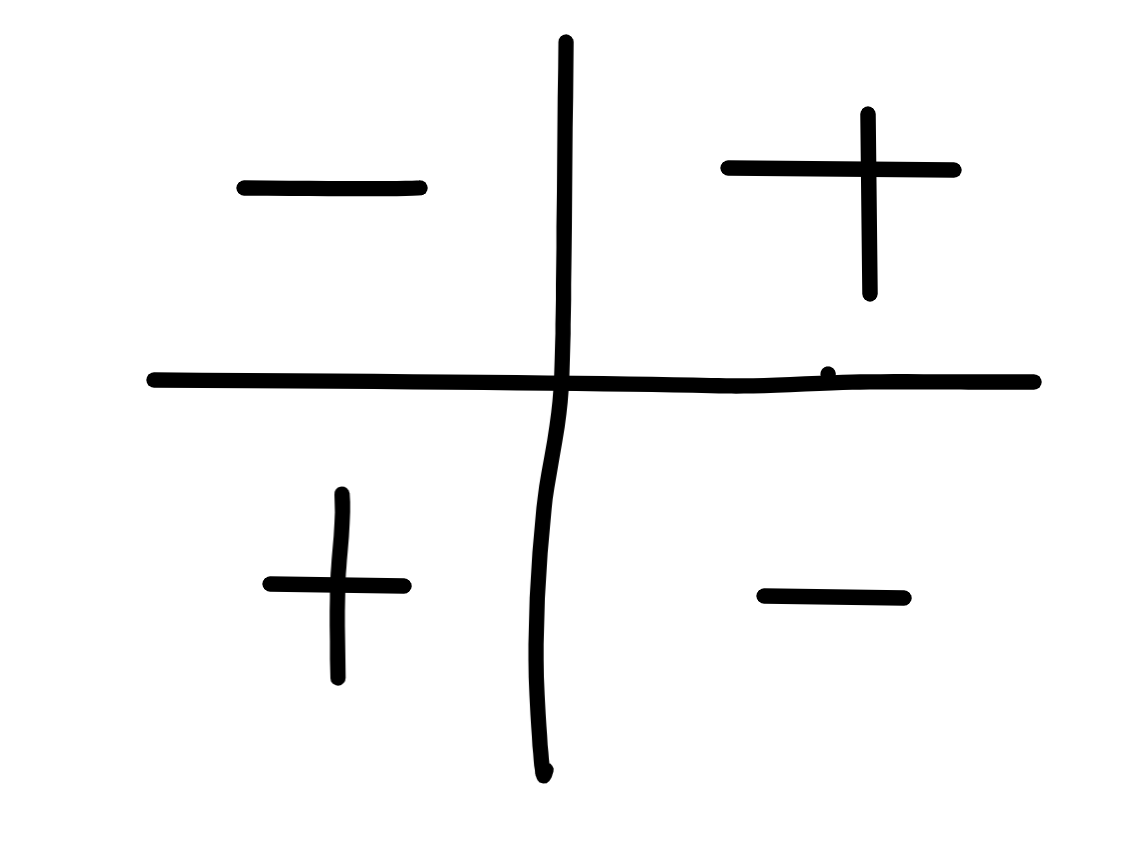

| x1 x x2 | label |
|---------|------:|
| AC      |     + |
| BC      |     - |
| AD      |     + |
| BD      |     - |

The feature cross introduces four new boolean feautures for our model:
- AC where `x1 >= 0` and `x2 >= 0`
- BC where `x1 < 0` and `x2 >= 0`
- AD where `x1 >= 0` and `x2 < 0`
- BD where `x1 < 0` and `x2 < 0`

Each of these four boolean features (AC, BC, AD, BD) would get its own weight when training the model. This means we can treat each quadrant as its own feature. Since the original dataset was split perfectly by the buckets we created, a feature cross of A and B is able to linearly separate the dataset.

But this isn't a real world example. There is a NYC taxi ride [dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This dataset contains many features such as `pickup timestamp`, `pickup lon`, `dropoff lon`. etc... The label here is the `fare_amount`, which is the cost of the taxi ride. What feature crosses will be useful here?

Let's consider the `pickup timestamp`. From this feature, we can use information about the ride's hour and day of the week. Each of these is a categoical variable and certainly both contain predictive power in determining the price of a taxi ride. For this dataset is makes sense to condider a feature corss of `day_of_week` and `hour_of_day` since it's reasonable to assume that taxi rides at 5pm on Monday should be treated differently than taxi rides at 5pm on Friday. Table below shows the feature cross:

| day_of_week | hour_of_day |
|-------------|------------:|
| Sunday      |          00 |
| Sunday      |          01 |
| ...         |         ... |
| Saturday    |          23 |

A feature cross of these two features would be a 168-dimensional one-hot encoded vector (24 hours * 7 days). Monday at 5pm occupies a single index denoting the `day_of_week` is Monday conatenated with `hour_of_day` is 17.

While the two features are important on their own, allowing for a feature cross of `hour_or_day` and `day_of_week` makes it easer for a taxi fair prediction model to recognise that end-of-the-week rush hour influences the taxi ride duration and thus taxi fare in it's own way.